# Analyse information gain from topology features vs geometric


**Imports**

In [19]:
import os
import csv
import json
import math
import re
from dataclasses import dataclass
from glob import glob
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np

# --- paths ---
REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUT_ROOT = REPO_ROOT / "out"
SAVE_DIR = OUT_ROOT / "_analysis" / "knn_vs_topo_adv"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- make matplotlib/fontconfig caches writable (important in sandboxed envs) ---
os.environ.setdefault("MPLBACKEND", "Agg")
os.environ.setdefault("MPLCONFIGDIR", str(REPO_ROOT / ".mplcache"))
os.environ.setdefault("XDG_CACHE_HOME", str(REPO_ROOT / ".cache"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)
(Path(os.environ["XDG_CACHE_HOME"]) / "fontconfig").mkdir(parents=True, exist_ok=True)

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score

In [20]:
G_KEYS = ["degree", "laplacian"]
EPS_RE = re.compile(r"(?:base_e_|e[_=])([0-9]+(?:\.[0-9]+)?)", re.IGNORECASE)


def _read_json(path: Path) -> Dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def _read_csv(path: Path) -> List[Dict[str, str]]:
    with open(path, "r", encoding="utf-8", newline="") as f:
        return list(csv.DictReader(f))


def _infer_eps(s: str) -> Optional[str]:
    m = EPS_RE.search(str(s).replace("__", "_"))
    return m.group(1) if m else None


def _infer_regime(s: str) -> str:
    ss = str(s).lower()
    if "ood" in ss:
        return "ood"
    if "topology_only" in ss:
        return "topology_only"
    if "baseline" in ss:
        return "baseline"
    return "combined"


def _is_adv_experiment(config_relpath: str) -> bool:
    return "ood" not in str(config_relpath).lower()


def _normalize_run_dir(p: str, *, out_root: Path) -> Path:
    """Map Windows run_dir strings to local out_root when needed."""
    pp = str(p)
    if Path(pp).exists():
        return Path(pp)
    p2 = pp.replace("\\", "/")
    idx = p2.lower().find("/out/")
    if idx >= 0:
        suffix = p2[idx + 5 :]
        return out_root.joinpath(*suffix.split("/"))
    return Path(p2)


def _trial_auc(run_dir: Path) -> Optional[float]:
    mp = run_dir / "metrics" / "metrics.json"
    if not mp.exists():
        return None
    d = _read_json(mp)
    m_adv = d.get("metrics_adv") or {}
    try:
        v = float(m_adv.get("roc_auc"))
        return v if math.isfinite(v) else None
    except Exception:
        return None


def _pick_best_trial_by_auc(study_dir: Path) -> Optional[Path]:
    best_dir = None
    best_auc = None
    for rd in sorted((study_dir / "runs" / "trials").glob("trial_*") ):
        auc = _trial_auc(rd)
        if auc is None:
            continue
        if best_auc is None or auc > best_auc:
            best_auc = auc
            best_dir = rd
    return best_dir


@dataclass(frozen=True)
class BestTrial:
    dataset: str
    eps: Optional[str]
    regime: str
    config_relpath: str
    run_dir: Path


def collect_best_trials(out_root: Path) -> List[BestTrial]:
    best: List[BestTrial] = []

    json_summaries = sorted(out_root.glob("*/_aggregate/summary.json"))
    csv_summaries = sorted(out_root.glob("*/_aggregate/summary.csv"))
    csv_by_ds = {p.parent.parent.name: p for p in csv_summaries}

    for p in json_summaries:
        ds = p.parent.parent.name
        d = _read_json(p)
        for run in d.get("runs", []):
            if run.get("status") != "success":
                continue
            cfg_rel = str(run.get("config_relpath", ""))
            if not _is_adv_experiment(cfg_rel):
                continue
            best_obj = run.get("best") or {}
            rd = best_obj.get("run_dir")
            if rd:
                run_dir = _normalize_run_dir(str(rd), out_root=out_root)
            else:
                study_dir = run.get("study_dir")
                if not study_dir:
                    continue
                study_dir_p = _normalize_run_dir(str(study_dir), out_root=out_root)
                run_dir = _pick_best_trial_by_auc(study_dir_p)
                if run_dir is None:
                    continue

            eps = _infer_eps(cfg_rel) or _infer_eps(str(run_dir))
            regime = _infer_regime(cfg_rel)
            if regime == "ood":
                continue
            best.append(BestTrial(dataset=ds, eps=eps, regime=regime, config_relpath=cfg_rel, run_dir=Path(run_dir)))

    # CSV-only fallback
    for ds, p in csv_by_ds.items():
        if any(bt.dataset == ds for bt in best):
            continue
        for r in _read_csv(p):
            if r.get("status") != "success":
                continue
            cfg_rel = str(r.get("config_relpath", ""))
            if not _is_adv_experiment(cfg_rel):
                continue
            study_dir = r.get("study_dir")
            if not study_dir:
                continue
            study_dir_p = _normalize_run_dir(study_dir, out_root=out_root)
            run_dir = _pick_best_trial_by_auc(study_dir_p)
            if run_dir is None:
                continue
            eps = _infer_eps(cfg_rel) or _infer_eps(str(study_dir_p))
            regime = _infer_regime(cfg_rel)
            if regime == "ood":
                continue
            best.append(BestTrial(dataset=ds, eps=eps, regime=regime, config_relpath=cfg_rel, run_dir=Path(run_dir)))

    return best


def _feature_dir(run_dir: Path) -> Path:
    return run_dir / "raw" / "features"


def _available_topo_keys(run_dir: Path, split: str = "test_clean") -> List[str]:
    feat_dir = _feature_dir(run_dir)
    if not feat_dir.is_dir():
        return []
    pref = f"{split}__topo_"
    keys = []
    for fn in os.listdir(feat_dir):
        if fn.startswith(pref) and fn.endswith(".npy"):
            keys.append(fn.replace(f"{split}__", "").replace(".npy", ""))
    keys.sort()
    return keys


def _load_col(run_dir: Path, split: str, key: str) -> np.ndarray:
    p = _feature_dir(run_dir) / f"{split}__{key}.npy"
    return np.load(p).astype(float, copy=False).reshape(-1, 1)


def _load_block(run_dir: Path, split: str, keys: Sequence[str]) -> np.ndarray:
    cols = [_load_col(run_dir, split, k) for k in keys]
    return np.concatenate(cols, axis=1)


def _make_xy(run_dir: Path, split_clean: str, split_adv: str, keys: Sequence[str]) -> Tuple[np.ndarray, np.ndarray]:
    x0 = _load_block(run_dir, split_clean, keys)
    x1 = _load_block(run_dir, split_adv, keys)
    y = np.concatenate([np.zeros(x0.shape[0], dtype=int), np.ones(x1.shape[0], dtype=int)])
    x = np.concatenate([x0, x1], axis=0)
    return x, y


def _standardize_fit(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    mu = np.mean(x, axis=0)
    sd = np.std(x, axis=0, ddof=0)
    sd = np.where(sd > 0, sd, 1.0)
    return mu, sd


def _standardize_apply(x: np.ndarray, mu: np.ndarray, sd: np.ndarray) -> np.ndarray:
    return (x - mu) / sd


def auc_from_probe(run_dir: Path, keys: Sequence[str]) -> Tuple[float, int, int, int, int]:
    xtr, ytr = _make_xy(run_dir, "val_clean", "val_adv", keys)
    xte, yte = _make_xy(run_dir, "test_clean", "test_adv", keys)

    n_tr0 = int(np.sum(ytr == 0))
    n_tr1 = int(np.sum(ytr == 1))
    n_te0 = int(np.sum(yte == 0))
    n_te1 = int(np.sum(yte == 1))

    # Thresholds: require enough successful adversarial samples
    if n_tr0 < 5 or n_tr1 < 5 or n_te0 < 5 or n_te1 < 1:
        return float("nan"), n_tr0, n_tr1, n_te0, n_te1

    mu, sd = _standardize_fit(xtr)
    xtr = _standardize_apply(xtr, mu, sd)
    xte = _standardize_apply(xte, mu, sd)

    clf = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=2000)
    clf.fit(xtr, ytr)
    p1 = clf.predict_proba(xte)[:, 1]
    auc = float(roc_auc_score(yte, p1)) if len(np.unique(yte)) == 2 else float("nan")
    return auc, n_tr0, n_tr1, n_te0, n_te1


def auc_residual_topo(run_dir: Path, topo_keys: Sequence[str]) -> Tuple[float, int, int, int, int]:
    xg_tr, ytr = _make_xy(run_dir, "val_clean", "val_adv", G_KEYS)
    xt_tr, _ = _make_xy(run_dir, "val_clean", "val_adv", topo_keys)
    xg_te, yte = _make_xy(run_dir, "test_clean", "test_adv", G_KEYS)
    xt_te, _ = _make_xy(run_dir, "test_clean", "test_adv", topo_keys)

    n_tr0 = int(np.sum(ytr == 0))
    n_tr1 = int(np.sum(ytr == 1))
    n_te0 = int(np.sum(yte == 0))
    n_te1 = int(np.sum(yte == 1))
    if n_tr0 < 5 or n_tr1 < 5 or n_te0 < 5 or n_te1 < 1:
        return float("nan"), n_tr0, n_tr1, n_te0, n_te1

    mu_g, sd_g = _standardize_fit(xg_tr)
    xg_tr_s = _standardize_apply(xg_tr, mu_g, sd_g)
    xg_te_s = _standardize_apply(xg_te, mu_g, sd_g)

    reg = Ridge(alpha=1.0)
    reg.fit(xg_tr_s, xt_tr)
    r_tr = xt_tr - reg.predict(xg_tr_s)
    r_te = xt_te - reg.predict(xg_te_s)

    mu_r, sd_r = _standardize_fit(r_tr)
    r_tr_s = _standardize_apply(r_tr, mu_r, sd_r)
    r_te_s = _standardize_apply(r_te, mu_r, sd_r)

    clf = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=2000)
    clf.fit(r_tr_s, ytr)
    p1 = clf.predict_proba(r_te_s)[:, 1]
    auc = float(roc_auc_score(yte, p1)) if len(np.unique(yte)) == 2 else float("nan")
    return auc, n_tr0, n_tr1, n_te0, n_te1






In [21]:
best = collect_best_trials(OUT_ROOT)
by_key: Dict[Tuple[str, Optional[str], str], BestTrial] = {}
for bt in best:
    by_key.setdefault((bt.dataset, bt.eps, bt.regime), bt)

datasets = sorted({bt.dataset for bt in best})
eps_vals = sorted({bt.eps for bt in best if bt.eps is not None})

rows_out: List[Dict[str, object]] = []
for ds in datasets:
    for eps in eps_vals:
        b_baseline = by_key.get((ds, eps, "baseline"))
        b_topo_only = by_key.get((ds, eps, "topology_only"))
        b_combined = by_key.get((ds, eps, "combined"))

        auc_g_baseline = float("nan")
        auc_t_topo_only = float("nan")
        auc_g = float("nan")
        auc_t = float("nan")
        auc_gt = float("nan")
        auc_t_resid = float("nan")
        topo_cnt = ""
        n_te0 = ""
        n_te1 = ""

        if b_baseline is not None:
            try:
                auc_g_baseline, *_ = auc_from_probe(b_baseline.run_dir, G_KEYS)
            except Exception:
                pass

        if b_topo_only is not None:
            try:
                topo_keys = _available_topo_keys(b_topo_only.run_dir)
                if topo_keys:
                    auc_t_topo_only, *_ = auc_from_probe(b_topo_only.run_dir, topo_keys)
            except Exception:
                pass

        if b_combined is not None:
            try:
                topo_keys = _available_topo_keys(b_combined.run_dir)
                topo_cnt = len(topo_keys)
                if topo_keys:
                    auc_g, tr0, tr1, te0, te1 = auc_from_probe(b_combined.run_dir, G_KEYS)
                    n_te0, n_te1 = te0, te1
                    auc_t, *_ = auc_from_probe(b_combined.run_dir, topo_keys)
                    auc_gt, *_ = auc_from_probe(b_combined.run_dir, list(G_KEYS) + list(topo_keys))
                    auc_t_resid, *_ = auc_residual_topo(b_combined.run_dir, topo_keys)
            except Exception:
                pass
        else:
            if math.isfinite(auc_g_baseline):
                auc_g = auc_g_baseline
            if math.isfinite(auc_t_topo_only):
                auc_t = auc_t_topo_only

        delta = auc_gt - auc_g if (math.isfinite(auc_gt) and math.isfinite(auc_g)) else float("nan")
        if not any(math.isfinite(x) for x in [auc_g, auc_t, auc_gt, auc_t_resid, auc_g_baseline, auc_t_topo_only]):
            continue

        rows_out.append(
            {
                "dataset": ds,
                "eps": eps,
                "run_dir_baseline": str(b_baseline.run_dir) if b_baseline else "",
                "run_dir_topology_only": str(b_topo_only.run_dir) if b_topo_only else "",
                "run_dir_combined": str(b_combined.run_dir) if b_combined else "",
                "auc_G_baseline": auc_g_baseline,
                "auc_T_topology_only": auc_t_topo_only,
                "auc_G": auc_g,
                "auc_T": auc_t,
                "auc_GT": auc_gt,
                "delta_auc_topo": delta,
                "auc_T_resid": auc_t_resid,
                "topo_feature_count_GT": topo_cnt,
                "n_test_clean_G": n_te0,
                "n_test_adv_G": n_te1,
            }
        )

# write CSV
summary_csv = SAVE_DIR / "ablation_adv_summary.csv"
cols = list(rows_out[0].keys()) if rows_out else []
with open(summary_csv, "w", encoding="utf-8", newline="") as f:
    w = csv.DictWriter(f, fieldnames=cols)
    w.writeheader()
    w.writerows(rows_out)

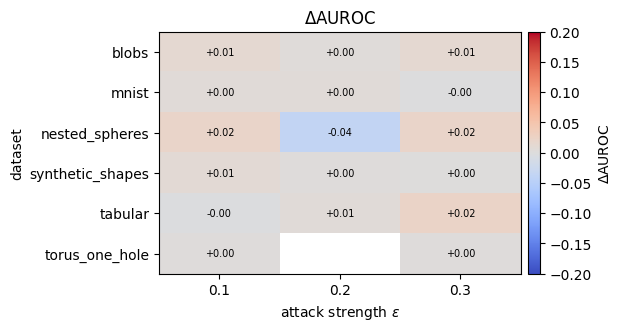

In [ ]:
# plots
import matplotlib.pyplot as plt

def plot_delta_heatmap(rows: List[Dict[str, object]], out_path: Optional[Path] = None):
    datasets = sorted({str(r["dataset"]) for r in rows})
    eps_vals = sorted({str(r["eps"]) for r in rows})
    mat = np.full((len(datasets), len(eps_vals)), np.nan, dtype=float)
    idx_ds = {d: i for i, d in enumerate(datasets)}
    idx_eps = {e: j for j, e in enumerate(eps_vals)}
    for r in rows:
        v = r.get("delta_auc_topo")
        if v is None:
            continue
        i = idx_ds[str(r["dataset"])]
        j = idx_eps[str(r["eps"])]
        try:
            mat[i, j] = float(v)
        except Exception:
            pass

    fig, ax = plt.subplots(figsize=(6.1, max(3.2, 0.35 * len(datasets))), constrained_layout=True)
    im = ax.imshow(mat, aspect="auto", cmap="coolwarm", vmin=-0.2, vmax=0.2)
    ax.set_title(r"$\Delta$AUROC")
    ax.set_xlabel(r"attack strength $\epsilon$")
    ax.set_ylabel("dataset")
    ax.set_xticks(np.arange(len(eps_vals)))
    ax.set_xticklabels(eps_vals)
    ax.set_yticks(np.arange(len(datasets)))
    ax.set_yticklabels(datasets)
    c = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    c.set_label(r"$\Delta$AUROC")
    for i in range(len(datasets)):
        for j in range(len(eps_vals)):
            if np.isfinite(mat[i, j]):
                ax.text(j, i, f"{mat[i,j]:+.2f}", ha="center", va="center", fontsize=7, color="black")

    if out_path is not None:
        fig.savefig(out_path, dpi=220, bbox_inches="tight")
        plt.close(fig)
        return None


plot_delta_heatmap(rows_out)

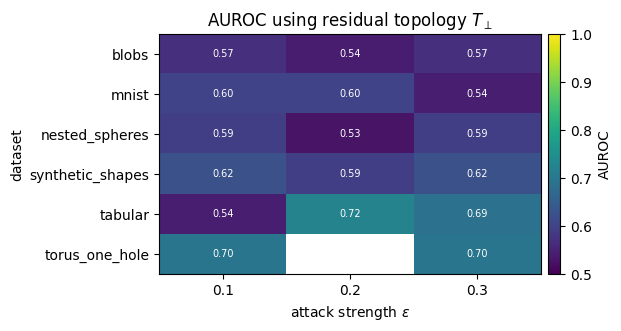

In [25]:
def plot_resid_heatmap(rows: List[Dict[str, object]], out_path: Optional[Path] = None):
    datasets = sorted({str(r["dataset"]) for r in rows})
    eps_vals = sorted({str(r["eps"]) for r in rows})
    mat = np.full((len(datasets), len(eps_vals)), np.nan, dtype=float)
    idx_ds = {d: i for i, d in enumerate(datasets)}
    idx_eps = {e: j for j, e in enumerate(eps_vals)}
    for r in rows:
        v = r.get("auc_T_resid")
        if v is None:
            continue
        i = idx_ds[str(r["dataset"])]
        j = idx_eps[str(r["eps"])]
        try:
            mat[i, j] = float(v)
        except Exception:
            pass

    fig, ax = plt.subplots(figsize=(6.1, max(3.2, 0.35 * len(datasets))), constrained_layout=True)
    im = ax.imshow(mat, aspect="auto", cmap="viridis", vmin=0.5, vmax=1.0)
    ax.set_title(r"AUROC using residual topology $T_{\perp}$")
    ax.set_xlabel(r"attack strength $\epsilon$")
    ax.set_ylabel("dataset")
    ax.set_xticks(np.arange(len(eps_vals)))
    ax.set_xticklabels(eps_vals)
    ax.set_yticks(np.arange(len(datasets)))
    ax.set_yticklabels(datasets)
    c = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    c.set_label("AUROC")
    for i in range(len(datasets)):
        for j in range(len(eps_vals)):
            if np.isfinite(mat[i, j]):
                ax.text(j, i, f"{mat[i,j]:.2f}", ha="center", va="center", fontsize=7, color="white")

    if out_path is not None:
        fig.savefig(out_path, dpi=220, bbox_inches="tight")
        plt.close(fig)
        return None
        
plot_resid_heatmap(rows_out)
